# Outline
- Brightness and Contrast
- Shadow clipping & Highlight clipping
- Gamma correction
- Shadows, Midtone, Highlight

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

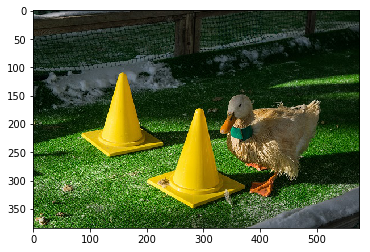

In [2]:
# Read image data
img = plt.imread('data/duck.jpg')
plt.imshow(img)

# Brief understanding of black and white
The RGB value range 0-255. If all of the values (every pixels) are 255, it will become a white image. Contrastly, if all of them are 0, it will become a black image. The examples are shown below.

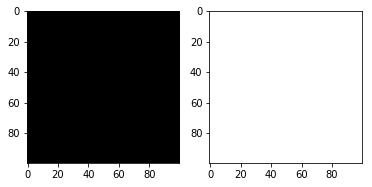

In [3]:
# display black and white image
img_size = (100,100,3)
black_img = np.zeros(img_size).astype(np.uint8) # all 0
white_img = np.ones(img_size).astype(np.uint8) * 255 # all 255

fig, axes = plt.subplots(1,2)
axes[0].imshow(black_img)
axes[1].imshow(white_img)

# Formular for brightness and contrast
$$g(x) = \alpha f(x) + \beta$$
which

- $f(x)$ is the input image as pixel value (RGB)
- $g(x)$ is the output image as pixel value (RGB)
- $\alpha > 0$ is "gain", controlling contrast.
- $\beta$ is "bias", controlling brightness.

If the values exceed 0 or 255, it will be clipped (ex. 270 will be clipped into 255 and -3 will be clipped into 0)

In Adobe Lightroom, they are called **Shadow Clipping** and **Highlight clipping**

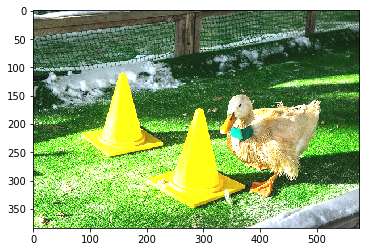

In [4]:
# Example, change the value to test
# Note: don't forget to change the type from uint8 to float32 before any operation
alpha = 2.0
beta = 20
edited_img = np.clip(img.astype(np.float32) * alpha + beta, 0, 255).astype(np.uint8) #clipped [0,255]
plt.imshow(edited_img)

# Uhhh...
The problem here, by increasing the gain (contrast), the picture get bright unwillingly.

We reformed the equation to prevent the gain from exploding the image values.

$$g(x) = \alpha(f(x) - 128) + 128 + \beta$$

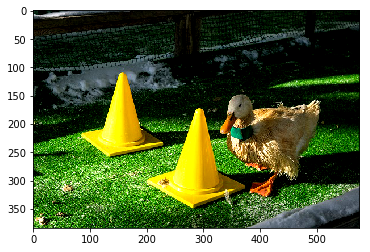

In [5]:
# Example, change the value to test
alpha = 1.5
beta = 20
high_con_img = np.clip((img.astype(np.float32) - 128) * alpha + 128 + beta, 0, 255).astype(np.uint8)
plt.imshow(high_con_img)

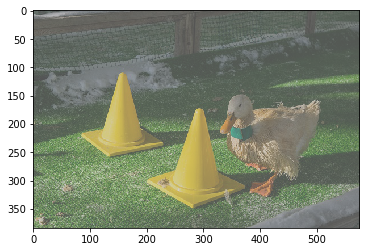

In [17]:
# Example, low contrast
alpha = 0.5
beta = 20
low_con_img = np.clip((img.astype(np.float32) - 128) * alpha + 128 + beta, 0, 255).astype(np.uint8)
plt.imshow(low_con_img)

Look much better

# Plot histogram of brightness
Actually brightness is hard to define so that I purpose a simple way to do it.

First, we transform the image into gray-scale then plot the histrogram directly from the pixels' value.

Image -> gray-scale image -> Pixel histrogram

Note that grayscale pixel can be calculated as the following equation

$$g_i = 0.2989\times r_i + 0.5870\times g_i + 0.1140\times b_i$$

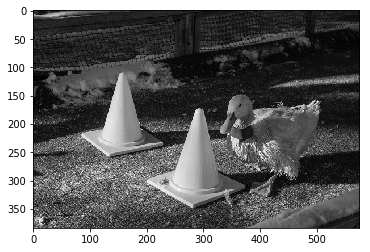

In [7]:
# Gray scale
def gray_scale(img):
     return np.dot(img[...,:3], [0.2989, 0.5870, 0.1140])
    
plt.imshow(gray_scale(img).astype(np.uint8), cmap='gray')

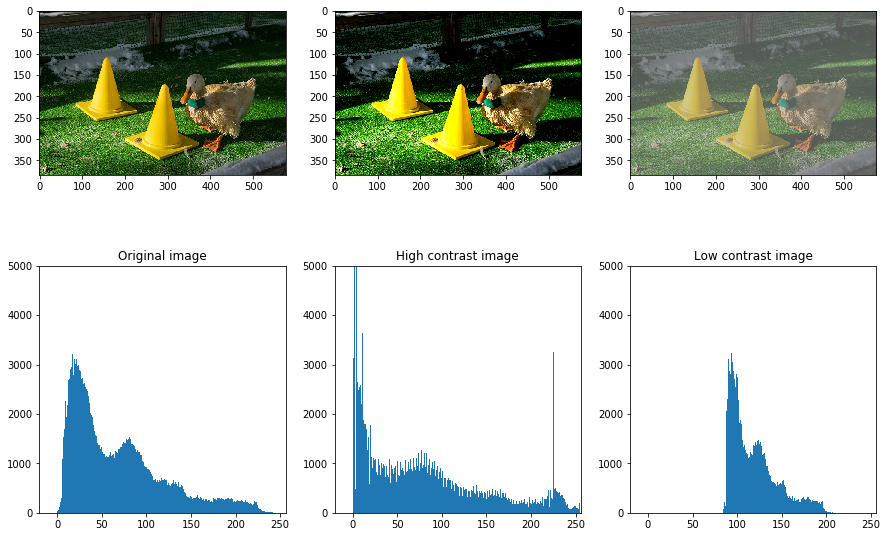

In [8]:
# Let's plot a simple histrogram
# There are 3 images, original, high contrast, low contrast
flatten_img = gray_scale(img).flatten() # Make image into 1-D Array
flatten_high_con_img = gray_scale(high_con_img).flatten()
flatten_low_con_img = gray_scale(low_con_img).flatten()

figs, axes = plt.subplots(2,3, figsize=(15,10))
axes[0][0].imshow(img)
axes[0][1].imshow(high_con_img)
axes[0][2].imshow(low_con_img)
_ = axes[1][0].hist(flatten_img, bins=256)
_ = axes[1][1].hist(flatten_high_con_img, bins=256)
_ = axes[1][2].hist(flatten_low_con_img, bins=256)
axes[1][0].set_title('Original image')
axes[1][1].set_title('High contrast image')
axes[1][2].set_title('Low contrast image')

for axe in axes[1]:
    axe.set_xlim((-20, 256))
    axe.set_ylim((0,5000))

plt.show()

# Shadow clipping & Highlight clipping
In lightroom, around the histogram there are 2 triangle bottom which said shadow clipping and highlight clipping when hovered by cursor. When activated, it will mask the image by red color for bright part and blue color for dark part which a value of pixel exceeded 255 or 0. This is a good warning of over adjusting brightness or contrast.

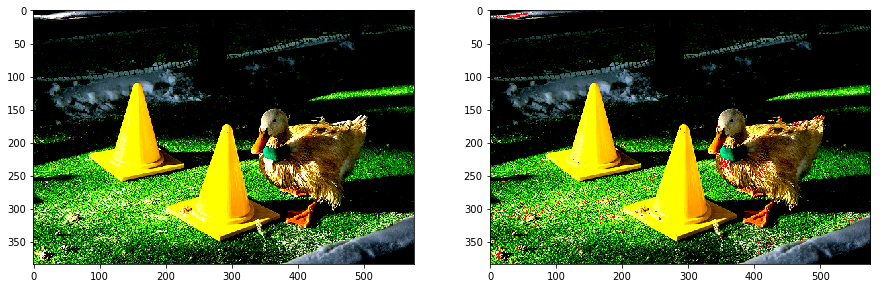

In [53]:
# Example, Hightlight clipping
alpha = 2.5
beta = 50
too_bright_img = (img.astype(np.float32) - 128) * alpha + 128 + beta
# Get the
max_pixel_img = np.min(too_bright_img, axis=-1)
masked_img = np.where(max_pixel_img > 255)
too_bright_img_masked = too_bright_img.copy()
too_bright_img_masked[masked_img] = [255, 0 ,0]

fig, axes = plt.subplots(1,2,figsize=(15,10))

axes[0].imshow(np.clip(too_bright_img, 0, 255).astype(np.uint8))
axes[1].imshow(np.clip(too_bright_img_masked, 0, 255).astype(np.uint8))

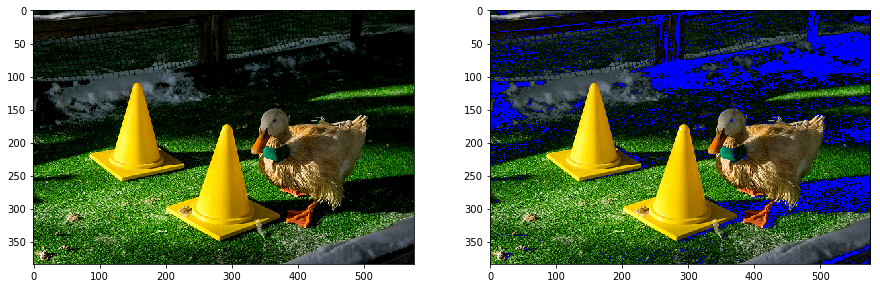

In [50]:
# Example, Shadow clipping
alpha = 1.2
beta = -5
too_dark_img = ((img.astype(np.float32) - 128) * alpha + 128 + beta)
max_pixel_img = np.max(too_dark_img, axis=-1)
masked_img = np.where(max_pixel_img < 0)
too_dark_img_masked = too_dark_img.copy()
too_dark_img_masked[masked_img] = [0, 0 ,255]

fig, axes = plt.subplots(1,2,figsize=(15,10))

axes[0].imshow(np.clip(too_dark_img, 0, 255).astype(np.uint8))
axes[1].imshow(np.clip(too_dark_img_masked, 0, 255).astype(np.uint8))

# Deal with the shadow part
This time, let's go with a picture consisted of both bright and dark parts

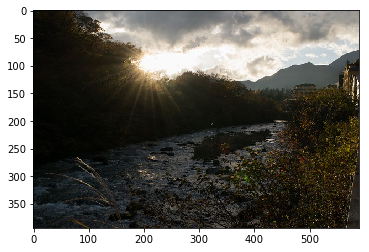

In [41]:
dark_img = plt.imread('data/dark.jpg')
plt.imshow(dark_img)

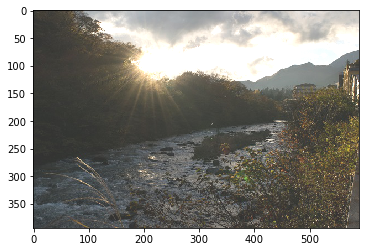

In [30]:
# Example
# Apply the previous transfomation
alpha = 1
beta = 50
edited_img = np.clip((dark_img.astype(np.float32) - 128) * alpha + 128 + beta, 0, 255).astype(np.uint8)
plt.imshow(edited_img)

# Gamma Correction
In many case (I think mostly), the brightness adjustment might not always be linear.

For example, a photo with shadow parts and bright parts. We might want to brighten the shadow part while not making the bright part to explode; in the other word, to make it change less. It can be easily dealt by finding a function with input and output which gave us a desireable values and one of the non-linear transformation function is gamma correction as the following.

$$O = \left(\frac{I}{255}\right)^\gamma\times 255$$

which I - input, O - output, gamma - see below

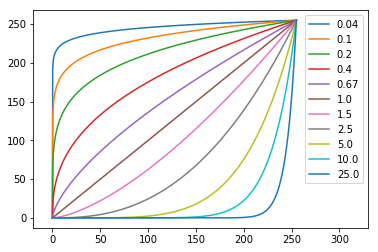

In [37]:
# Here is the plots for different values of gamma
# gamma < 1 means brightening
# gamma > 1 means darkening
gammas = [0.04, 0.1, 0.2, 0.4, 0.67, 1., 1.5, 2.5, 5.0, 10.0, 25.0]
input_plot = np.linspace(0, 255, 1000)

def gamma_correct(x, gamma):
    return (x / 255.) ** gamma * 255.

for gamma in gammas:
    output_plot = gamma_correct(input_plot, gamma)
    plt.plot(input_plot, output_plot, label='{}'.format(gamma))


plt.xlim((-20, 330)) # add space for legend
plt.legend()
plt.show()

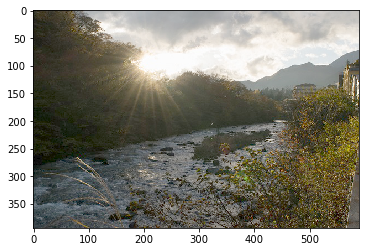

In [32]:
# Example gamma < 1
gamma = 0.5
edited_img = gamma_correct(dark_img.astype(np.float32), gamma).astype(np.uint8)
plt.imshow(edited_img)

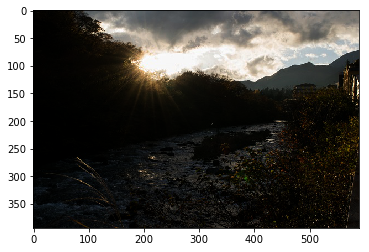

In [40]:
# Example gamma > 1
gamma = 1.5
edited_img = gamma_correct(dark_img.astype(np.float32), gamma).astype(np.uint8)
plt.imshow(edited_img)

# Reference
https://docs.opencv.org/3.4/d3/dc1/tutorial_basic_linear_transform.html